In [1]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 6.2 MB/s 


In [2]:
import mahotas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import os
from pathlib import Path
from PIL import Image, ImageOps
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### **Load Images and Extract TAS Descriptors**

In [4]:
image_dir = "/gdrive/My Drive/Project/Denoised_CLAHE_Cl3"

In [5]:
def load_data(tag='train'):
  tag_dir = os.path.join(image_dir, tag)
  tag_path = Path(tag_dir)
  data = [] # Images
  cat = [] # Category
  subcat = []
  patient = []
  file_name = []
  for mag_dir in tag_path.iterdir():  
    mag_label = mag_dir.stem
    print("*",mag_label)
    if mag_label == "40X":
      print("Got it!")
      for img_name in mag_dir.glob('*.png'):
        img_label = img_name.stem
        splitted_image_name = img_label.split('_')
        cat_label = splitted_image_name[1]
        remaining_part = splitted_image_name[2].split('-')
        subcat_label = remaining_part[0]
        patient_label = remaining_part[2]
        img = mahotas.imread(img_name.as_posix())
        img = img[:, :, 0]
        feature = mahotas.features.pftas(img)
        data.append(feature) # append the feature to the data
        cat.append(cat_label) # append the label to the category
        subcat.append(subcat_label)
        patient.append(patient_label)
        file_name.append(img_label)
  return data, cat, subcat, patient, file_name

In [6]:
# train images
vec_train, cat_train, subcat_train, patient_train, image_name_train = load_data('train')
# test images
vec_test, cat_test, subcat_test, patient_test, image_name_test = load_data('test')

* 40X
Got it!
* 100X
* 200X
* 400X
* 40X
Got it!
* 100X
* 200X
* 400X


### **List the Categories**

In [7]:
# Get unique categories for train data
labels = list(np.unique(np.array(subcat_train))) # convert categories to the numpy array and get unique values
labels

['A', 'DC', 'F', 'LC', 'MC', 'PC', 'PT', 'TA']

In [8]:
# Get unique categories for test data
labels = list(np.unique(np.array(subcat_test)))
labels

['A', 'DC', 'F', 'LC', 'MC', 'PC', 'PT', 'TA']

### **Label Encoding**

In [9]:
le = LabelEncoder()
label_train = le.fit_transform(subcat_train) # Here fit is used to assign 0, 1, ..., or 7
label_test = le.transform(subcat_test) # Only transform is used since the fit is already done above

In [10]:
label_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
label_test

### **Checking Class Imbalance**

Class= DC n=566 (45.280%)
Class= LC n=73 (5.840%)
Class= MC n=143 (11.440%)
Class= PC n=98 (7.840%)
Class= A n=64 (5.120%)
Class= F n=173 (13.840%)
Class= PT n=51 (4.080%)
Class= TA n=82 (6.560%)


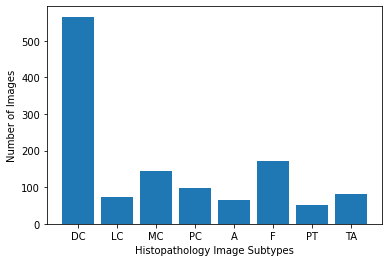

In [16]:
subtypes = ['A', 'DC', 'F', 'LC', 'MC', 'PC', 'PT', 'TA']
subtypes_order = ['DC', 'LC', 'MC', 'PC', 'A', 'F', 'PT', 'TA']
counter = Counter(label_train)
for k,v in counter.items():
	per = v / len(label_train) * 100
	print('Class=',subtypes[k], 'n=%d (%.3f%%)' % (v, per))
# plot the distribution
plt.bar(subtypes_order, counter.values())
plt.xlabel('Histopathology Image Subtypes')
plt.ylabel('Number of Images')
plt.show()

### **Function to Compute Patient Recognition Rate**

In [ ]:
def evaluate_recognition_rate(prediction):
  inverted_prediction = le.inverse_transform(prediction)
  unique_patient_test = list(np.unique(np.array(patient_test)))
  num_images_per_patient = []
  num_correctly_classified = []
  num = 0
  total_patient_score = 0
  num_patient = 0
  for patient in unique_patient_test:
    num_patient = num_patient + 1
    Np = 0
    Nrec = 0
    image_index_counter = -1
    for image_name in image_name_test:
      image_index_counter = image_index_counter + 1
      image_name_splitted = image_name.split('-')
      if patient == image_name_splitted[2]:
        first_part_splitted = image_name_splitted[0].split('_')
        image_class = first_part_splitted[2]
        if image_class == inverted_prediction[image_index_counter]:
          Nrec = Nrec + 1
        Np = Np + 1
    patient_score = Nrec/Np
    #print(patient_score)
    num_images_per_patient.append(Np)
    num_correctly_classified.append(Nrec)
    total_patient_score = total_patient_score + patient_score
    num = num + Np    
  recognition_rate = total_patient_score/num_patient
  print("Summation of patient score: ", total_patient_score)
  print("Total Number of Patients: ", num_patient)
  print("Recognition Rate: ", recognition_rate)

### **MLP**

In [ ]:
mlp = MLPClassifier(alpha=0.1, max_iter=1000)

In [ ]:
mlp.fit(vec_train,label_train)

MLPClassifier(alpha=0.1, max_iter=1000)

**Accuracy**

In [ ]:
# Test set evaluation
prediction = mlp.predict(vec_test)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 44.70%


**Area Under Curve**

In [ ]:
prediction_prob = mlp.predict_proba(vec_test)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.6145277267016642


In [ ]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

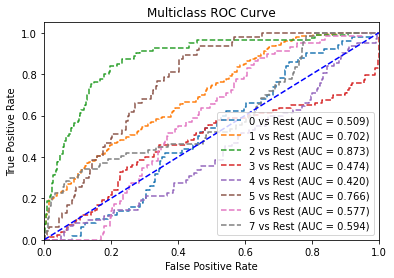

In [ ]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [ ]:
evaluate_recognition_rate(prediction)

Summation of patient score:  12.606798948269535
Total Number of Patients:  28
Recognition Rate:  0.45024281958105483


### **SVM Fit**

In [ ]:
pipe1 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", SVC(probability=True, kernel= 'rbf', gamma= 0.0001, C=200)) #radial basis function kernel
                 ])

In [ ]:
pipe1.fit(vec_train,label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', SVC(C=200, gamma=0.0001, probability=True))])

**Accuracy**

In [ ]:
# Test set evaluation
prediction = pipe1.predict(vec_test)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 46.17%


**Area Under Curve**

In [ ]:
prediction_prob = pipe1.predict_proba(vec_test)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.6651211064658233


In [ ]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

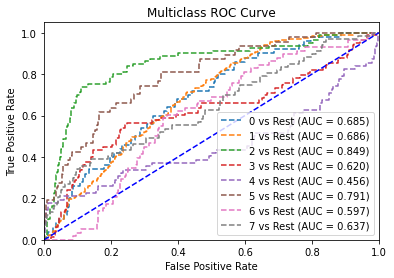

In [ ]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [ ]:
evaluate_recognition_rate(prediction)

Summation of patient score:  13.551853509774402
Total Number of Patients:  28
Recognition Rate:  0.4839947682062286


### **Random Forest**

In [ ]:
pipe2 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(n_estimators = 1000, random_state = 42, class_weight='balanced')) #100 gives 64.45
                 ])

In [ ]:
pipe2.fit(vec_train, label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=42))])

**Accuracy**

In [ ]:
# Test set evaluation
prediction = pipe2.predict(vec_test)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 41.88%


**Area Under Curve**

In [ ]:
prediction_prob = pipe2.predict_proba(vec_test)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.6069260902668949


In [ ]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

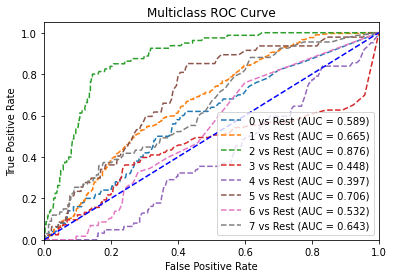

In [ ]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [ ]:
evaluate_recognition_rate(prediction)

Summation of patient score:  12.678335445815163
Total Number of Patients:  28
Recognition Rate:  0.4527976944933987


### **KNN**

In [ ]:
pipe3 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=27))
                 ])

In [ ]:
pipe3.fit(vec_train,label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=27))])

**Accuracy**

In [ ]:
# Test set evaluation
prediction = pipe3.predict(vec_test)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 39.87%


**Area Under Curve**

In [ ]:
prediction_prob = pipe3.predict_proba(vec_test)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.583305258247548


In [ ]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

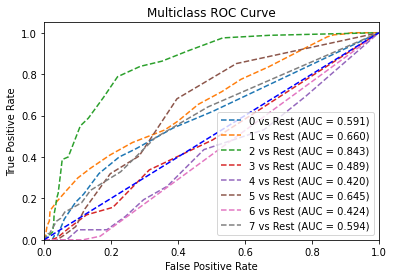

In [ ]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [ ]:
evaluate_recognition_rate(prediction)

Summation of patient score:  11.334310367643479
Total Number of Patients:  28
Recognition Rate:  0.40479679884440994


### **AdaBoost**

In [ ]:
pipe4 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", AdaBoostClassifier(learning_rate=0.01, n_estimators=100, random_state=42))
                 ])

In [ ]:
pipe4.fit(vec_train,label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 AdaBoostClassifier(learning_rate=0.01, n_estimators=100,
                                    random_state=42))])

**Accuracy**

In [ ]:
# Test set evaluation
prediction = pipe4.predict(vec_test)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 41.34%


**Area Under Curve**

In [ ]:
prediction_prob = pipe4.predict_proba(vec_test)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.573580379162683


In [ ]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

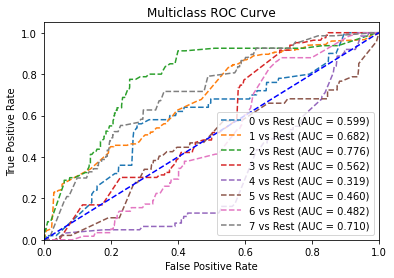

In [ ]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [ ]:
evaluate_recognition_rate(prediction)

Summation of patient score:  11.669108167220688
Total Number of Patients:  28
Recognition Rate:  0.4167538631150246


### **Xgboost**

In [ ]:
"""
pip install xgboost  
    
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)   
    
"""
mod1 = xgb.XGBClassifier(n_estimators=50)
vec_train_arr = np.array(vec_train)
vec_test_arr = np.array(vec_test)
mod1.fit(vec_train_arr, label_train)

XGBClassifier(n_estimators=50, objective='multi:softprob')

**Accuracy**

In [ ]:
# Test set evaluation
prediction = mod1.predict(vec_test)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 39.46%


**Area Under Curve**

In [ ]:
prediction_prob = mod1.predict_proba(vec_test)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.6225813989281666


In [ ]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

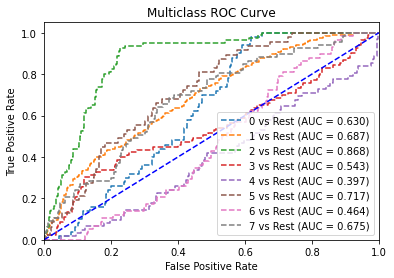

In [ ]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [ ]:
evaluate_recognition_rate(prediction)

Summation of patient score:  11.11733161163315
Total Number of Patients:  28
Recognition Rate:  0.39704755755832677


### **LightGBM**

In [ ]:
scaler = StandardScaler()
vec_train_scaled = scaler.fit_transform(vec_train)
vec_test_scaled = scaler.transform(vec_test)
d_train = lgb.Dataset(vec_train_scaled, label=label_train)

In [ ]:
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
lgbm_params = {'learning_rate':0.05, 'boosting_type':'gbdt', 
              'objective':'multiclass',
              'metric':'multi_logloss',
              'num_class':8,
              'num_leaves':100, # Optimize this to avoid overfitting. 50 to 100
              'max_depth':10} # 10 may be appropriate

In [ ]:
clf = lgb.train(lgbm_params, d_train, 50) #50 iterations. Increase iterations for small learning rates. eg if learning grate = 0.005, we may need 500 iterations.
prediction=clf.predict(vec_test_scaled)

In [ ]:
y_pred = [np.argmax(line) for line in prediction]

**Accuracy**

In [ ]:
# Test set evaluation
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,y_pred)*100))

Accuracy: 41.61%


**Area Under Curve**

In [ ]:
prediction_prob = clf.predict(vec_test_scaled)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.6154377713489723


In [ ]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

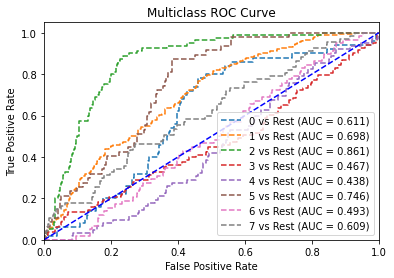

In [ ]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [ ]:
prediction = prediction.astype(int)
evaluate_recognition_rate(y_pred)

Summation of patient score:  12.604051232968708
Total Number of Patients:  28
Recognition Rate:  0.45014468689173953


### **Grid search to find the best model and parameters**

In [ ]:
# Defining a dictionary
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [0.1, 1, 5, 10, 100],  #Regularization parameter. We provide only two in order to have fast execution as SVM is slow
            'kernel': ['rbf','linear','sigmoid','poly'], #rbf and linear kernels
            'gamma':[0.00001,0.0001,0.001,0.01,0.1,1]
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [30,50,100] #trees. May lead to overfitting if n_estimators is too much
        }
    },
    'KNN' : {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1, 5, 9, 15, 19, 23, 27, 31, 35, 39]
        }
    }
}

In [ ]:
scores = []

for model_name, mp in model_params.items():
    grid =  GridSearchCV(estimator=mp['model'], 
                         param_grid=mp['params'], 
                         cv=5, n_jobs=6, #five fold cross validation
                         return_train_score=False)
    
    grid.fit(vec_train,label_train)
    
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

print(df)

                 model  best_score                               best_params
0                  svm    0.479588  {'C': 100, 'gamma': 1, 'kernel': 'poly'}
1        random_forest    0.466636                      {'n_estimators': 30}
2  logistic_regression    0.436479                                  {'C': 5}
